# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
#from scipy.misc import imread, imresize
import imageio
from imageio.v2 import imread
import skimage
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)

In [13]:
data_path = 'datasets/Project_data/'
train_doc = np.random.permutation(open(data_path+'train.csv').readlines())
train_path = data_path+'train'

val_doc = np.random.permutation(open(data_path+'val.csv').readlines())
val_path = data_path+'val'
#Experiment parameter
batch_size = 10 #Experiment -1

In [4]:
#Display Random image from Train and Validation set
import glob, random
train_img_folders=glob.glob("datasets/Project_data/train/*")
train_img = random.choice(glob.glob(random.choice(train_img_folders)+"/*.png"))

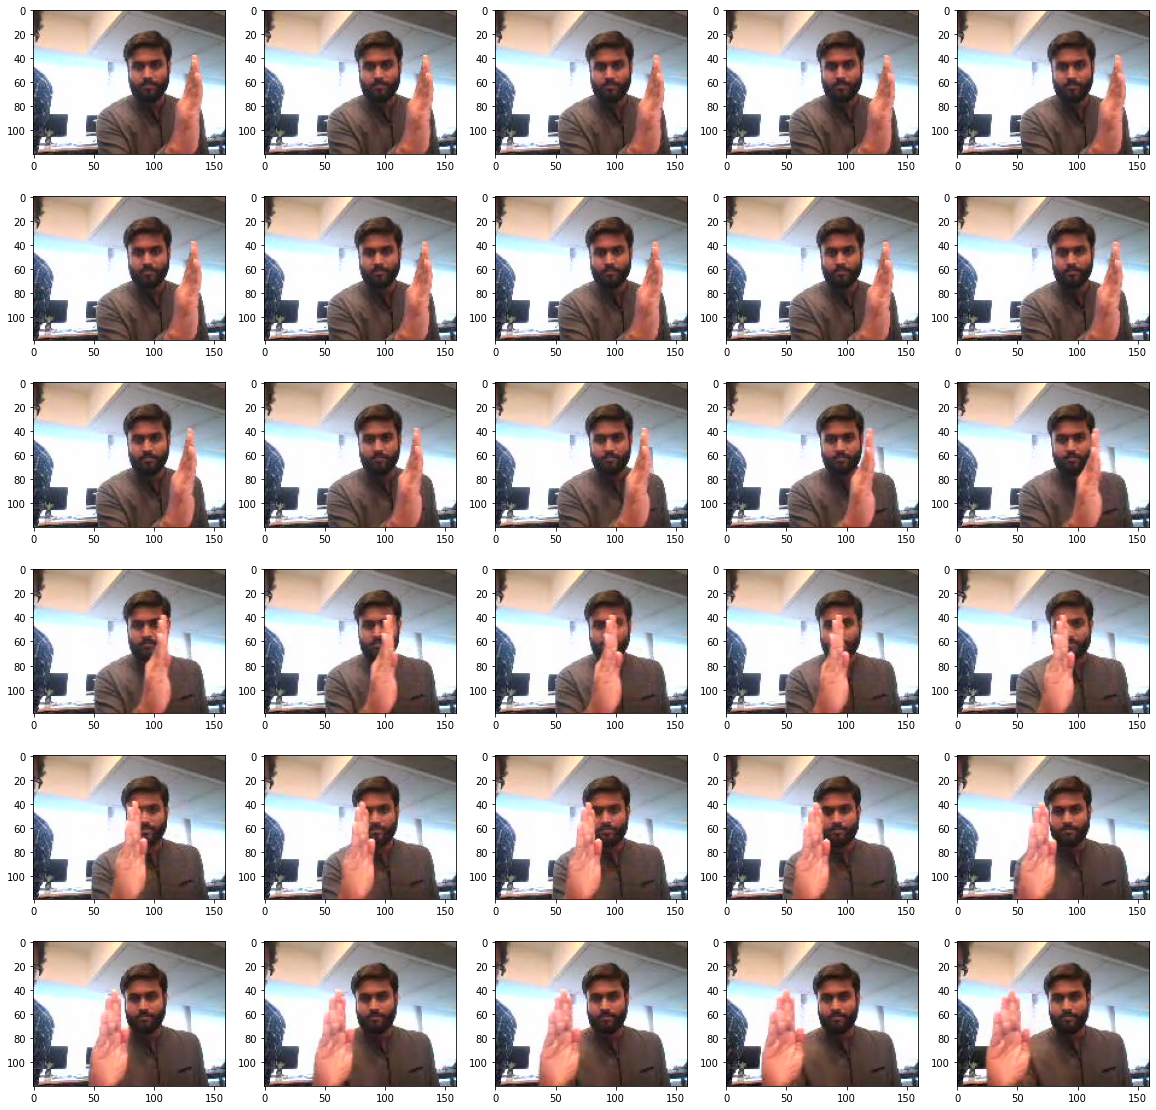

In [5]:
from PIL import Image
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20,20))
for ima, ax in zip(sorted(glob.glob(random.choice(train_img_folders)+"/*.png")), axs.flatten()):
    plt.sca(ax)
    plt.imshow(np.array(Image.open(ima)))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #experiment with all,even,odd and skip initial and last
    img_idx = range(0,30,2) #Experiment -1
    x = len(img_idx)
    y=z=120
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image,(120,120,3), mode='constant', preserve_range=True)
                    temp = image/255.0
                    #print(temp)
                    batch_data[folder,idx,:,:,0] = temp[:,:,0]
                    batch_data[folder,idx,:,:,1] = temp[:,:,0]
                    batch_data[folder,idx,:,:,2] = temp[:,:,1]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/notebooks/storage/Final_data/Collated_training/train'
val_path = '/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

#Conv3D
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(15,120,120,3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='softmax'))

2023-06-07 19:49:02.159406: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-07 19:49:02.159471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
from tensorflow.keras.optimizers import Adam
optimiser = Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 118, 118, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               2

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [15]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_303/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  datasets/Project_data/train ; batch size = 10
Epoch 1/5


2023-06-07 19:49:50.038622: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 6.0179 - categorical_accuracy: 0.3612Source path =  datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2023-06-0719_48_58.361959/model-00001-6.01790-0.36119-1.38779-0.45000.h5
67/67 [==============================] - 79s 1s/step - loss: 6.0179 - categorical_accuracy: 0.3612 - val_loss: 1.3878 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 2/5
67/67 [==============================] - ETA: 0s - loss: 0.8752 - categorical_accuracy: 0.6776
Epoch 00002: saving model to model_init_2023-06-0719_48_58.361959/model-00002-0.87523-0.67761-1.34584-0.57000.h5
67/67 [==============================] - 77s 1s/step - loss: 0.8752 - categorical_accuracy: 0.6776 - val_loss: 1.3458 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 3/5
67/67 [==============================] - ETA: 0s - loss: 0.5071 - categorical_accuracy: 0.8418
Epoch 00003: saving model to model_init_2023-06-0719_48_58.361959/model-00003-